In [1]:
import numpy as np
import glob
import requests
import graphviz as gv
from nltk.corpus import wordnet

In [2]:
BASE_URL = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/'

def perform_get_query(url):
    return requests.get(BASE_URL + url).json()

# Zadanie 3

Aby znaleźć wszystkie znaczenia rzeczownika 'szkoda' wypisałem pary zawierające opis sensu rzeczownika 'szkoda' i synonimy tego słowa powiązane z wybranym sensem

In [3]:
def get_senses_given_noun(lexeme):
    return perform_get_query(f'senses/search?lemma={lexeme}&&&partOfSpeech=noun')['content']

def get_synset_given_sense_id(sense_id):
    return perform_get_query(f'senses/{sense_id}/synset')

def get_senses_given_synset_id(synset_id):
    return perform_get_query(f'synsets/{synset_id}/senses')

In [4]:
def get_synonyms_given_sense_id(sense_id):
    synset_id = get_synset_given_sense_id(sense_id)['id']
    synset_senses = get_senses_given_synset_id(synset_id)
    return [sense['lemma']['word'] for sense in synset_senses]

In [5]:
meanings = []
senses = get_senses_given_noun('szkoda')
for sense in senses:
    description = sense['domain']['description']
    synonyms = get_synonyms_given_sense_id(sense['id'])
    meanings.append((description, synonyms))
meanings

[('plWN miejsca i umiejscowienie', ['szkoda']),
 ('plWN posiadanie i jego zmiana',
  ['strata', 'utrata', 'szkoda', 'uszczerbek'])]

# Zadanie 4

Utworzenie grafu domknięcia relacji hipernimi dla frazy 'wypadek drogowy'

In [6]:
def get_senses_given_lexeme(lexeme):
    return perform_get_query(f'senses/search?lemma={lexeme}')['content']

def get_relations_to_given_synset_id(synset_id):
    return perform_get_query(f'synsets/{synset_id}/relations/to')

In [7]:
first_sense = get_senses_given_lexeme('wypadek drogowy')[0]
first_sense_synset_id = get_synset_given_sense_id(first_sense['id'])['id']

synsets_relations = []
visited_synsets = []
synsets_ids = [first_sense_synset_id]

while len(synsets_ids) != 0:
    synset_id = synsets_ids.pop(0)
    visited_synsets.append(synset_id)
    relations_to_synset = get_relations_to_given_synset_id(synset_id)
    for relation in relations_to_synset:
        relation_name = relation['relation']['name']
        if relation_name != 'hiperonimia':
            continue
        corresponding_synset_id = relation['synsetFrom']['id']
        synsets_relations.append((corresponding_synset_id, synset_id, relation_name))
        if corresponding_synset_id in visited_synsets:
            continue
        synsets_ids.append(corresponding_synset_id)

synsets_relations

[(410901, 410902, 'hiperonimia'),
 (3982, 410901, 'hiperonimia'),
 (27419, 3982, 'hiperonimia'),
 (6526, 27419, 'hiperonimia')]

Utworzenie grafu z synsetami jako wierzchołki

<b>synonimy są pogrupowane w 1 wierzchołek (podobnie we wszystkich późniejszych grafach)</b>

In [8]:
def get_synonyms_given_synset_id(synset_id):
    synset_senses = get_senses_given_synset_id(synset_id)
    return [sense['lemma']['word'] for sense in synset_senses]

In [9]:
def get_synsets_graph(synsets, synsets_relations):
    words_per_sysnet = {synset_id: get_synonyms_given_synset_id(synset_id) for synset_id in synsets}
    synsets_labels = {synset_id: str(synset_id)+'\n'+'\n'.join(words_per_sysnet[synset_id]) for synset_id in synsets}
    synset_nodes = list(synsets_labels.values())
    synset_nodes_relations = []
    for synset_1, synset_2, relation_type in synsets_relations:
        synset_nodes_relations.append((synsets_labels[synset_1], synsets_labels[synset_2], relation_type))
    return synset_nodes, synset_nodes_relations

In [10]:
def generate_graph(nodes, relations):
    g = gv.Digraph(format="svg")
    for node in nodes:
        g.node(str(node))
    for relation in relations:
        g.edge(str(relation[0]), str(relation[1]), label=relation[2])
    return g

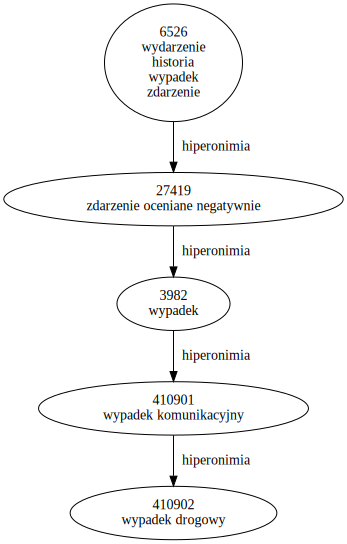

In [11]:
generate_graph(*get_synsets_graph(visited_synsets, synsets_relations))

# Zadanie 5

Znalezienie bezpośrednich hiponimów słowa wypadek (senseNumber 1)

In [12]:
def get_sense_given_noun_and_number(noun, number):
    senses = get_senses_given_noun(noun)
    for sense in senses:
        if sense['senseNumber'] == number:
            return sense

In [13]:
wypadek_1_sense_id = get_sense_given_noun_and_number('wypadek', 1)['id']
wypadek_1_synset_id = get_synset_given_sense_id(wypadek_1_sense_id)['id']

In [14]:
wypadek_relations = get_relations_to_given_synset_id(wypadek_1_synset_id)
hyponyms_synsets_ids = []
for relation in wypadek_relations:
    if relation['relation']['name'] == 'hiponimia':
        hyponyms_synsets_ids.append(relation['synsetFrom']['id'])
hyponyms_synsets_ids

[34688, 34689, 258635, 258639, 389170, 410901, 411618]

In [15]:
hyponyms = sum([get_synonyms_given_synset_id(synset_id) for synset_id in hyponyms_synsets_ids], [])
hyponyms

['zawał',
 'tąpnięcie',
 'katastrofa',
 'wykolejenie',
 'zakrztuszenie',
 'zachłyśnięcie',
 'wypadek komunikacyjny',
 'katastrofa budowlana']

# Zadanie 6

Znalezienie hiponimów drugiego stopnia (hiponimów hiponimów)

In [16]:
second_order_hyponyms_synsets_ids = []
for hyponyms_synset_id in hyponyms_synsets_ids:
    relations = get_relations_to_given_synset_id(hyponyms_synset_id)
    for relation in relations:
        if relation['relation']['name'] == 'hiponimia':
            second_order_hyponyms_synsets_ids.append(relation['synsetFrom']['id'])
second_order_hyponyms_synsets_ids

[37295, 410902]

In [17]:
second_order_hyponyms = sum([get_synonyms_given_synset_id(synset_id) for synset_id in second_order_hyponyms_synsets_ids], [])
second_order_hyponyms

['obwał', 'wypadek drogowy']

# Zadanie 7

Generacja grafów relacji semantycznych pomiędzy danymi słowami

In [18]:
A = {
    'szkoda': 2,
    'strata': 1, 
    'uszczerbek': 1, 
#     'szkoda majątkowa': 1, 
    'uszczerbek na zdrowiu': 1, 
    'krzywda': 1, 
    'niesprawiedliwość': 1, 
    'nieszczęście': 2
}

B = {
    'wypadek': 1, 
    'wypadek komunikacyjny': 1, 
    'kolizja': 2, 
    'zderzenie': 2, 
    'kolizja drogowa': 1, 
    'bezkolizyjny': 2, 
    'katastrofa budowlana': 1, 
    'wypadek drogowy': 1
}

In [19]:
def get_sense_given_lexeme_and_number(lexeme, number):
    senses = get_senses_given_lexeme(lexeme)
    for sense in senses:
        if sense['senseNumber'] == number:
            return sense
    return None
        
def get_relations_given_synset_id(synset_id):
    return perform_get_query(f'synsets/{synset_id}/relations')

In [20]:
def get_synsets_relations_given_lexemes(lexemes_dict):
    synset_to_lexem = {}
    for word, number in lexemes_dict.items():
        word_sense_id = get_sense_given_lexeme_and_number(word, number)['id']
        word_synset_id = get_synset_given_sense_id(word_sense_id)['id']
        synset_to_lexem[word_synset_id] = synset_to_lexem.get(word_synset_id, []) + [word]
        
    synsets = list(synset_to_lexem.keys())
    
    synsets_relations = set()
    for synset in synsets:
        relations = get_relations_given_synset_id(synset)
        for relation in relations:
            if relation['synsetFrom']['id'] in synsets and relation['synsetTo']['id'] in synsets:
                synsets_relations.add((relation['synsetFrom']['id'], relation['synsetTo']['id'], relation['relation']['name']))

    return synsets, synsets_relations

## Graf relacji semantycznych pomiędzy leksemami w grupie 1

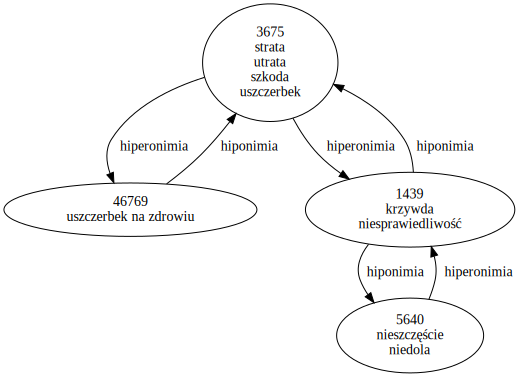

In [21]:
synsets, synsets_relations = get_synsets_relations_given_lexemes(A)
synset_nodes, synset_nodes_relations = get_synsets_graph(synsets, synsets_relations)
generate_graph(synset_nodes, synset_nodes_relations)

## Graf relacji semantycznych pomiędzy leksemami w grupie 2

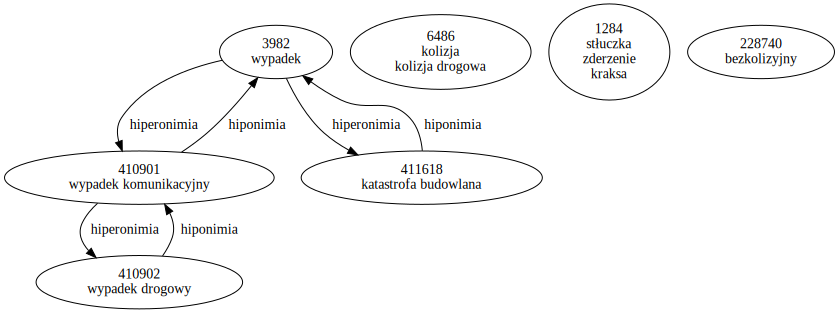

In [22]:
synsets, synsets_relations = get_synsets_relations_given_lexemes(B)
synset_nodes, synset_nodes_relations = get_synsets_graph(synsets, synsets_relations)
generate_graph(synset_nodes, synset_nodes_relations)

## Graf relacji semantycznych pomiędzy leksemami z obu grup

In [23]:
Lexemes = A
for key, value in B.items():
    Lexemes[key] = value

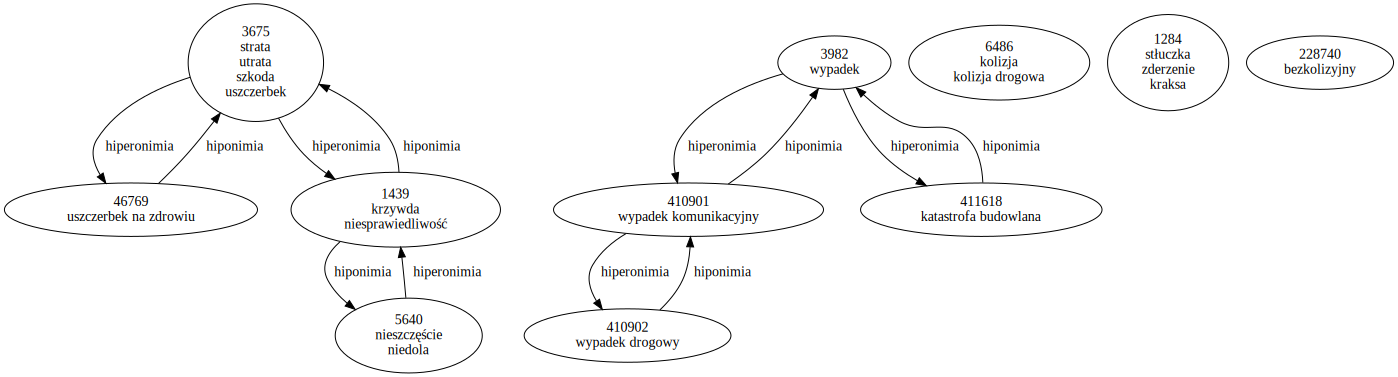

In [24]:
synsets, synsets_relations = get_synsets_relations_given_lexemes(Lexemes)
synset_nodes, synset_nodes_relations = get_synsets_graph(synsets, synsets_relations)
generate_graph(synset_nodes, synset_nodes_relations)

# Zadanie 8

Znajdywanie wartości miary podobieństwa semantycznego Leacock-Chodorow'a dla par leksemów

In [25]:
def calculate_lc_similarity(word_1, number_1, word_2, number_2):
    s1 = wordnet.synsets(word_1)[number_1 - 1]
    s2 = wordnet.synsets(word_2)[number_2 - 1]
    return wordnet.lch_similarity(s1, s2)

szkoda 2 i wypadek 1

In [26]:
calculate_lc_similarity('szkoda', 2, 'wypadek', 1)

2.740840023925201

kolizja 2 i szkoda majątkowa 1 (nie ma synsetów dla szkody majątkowej)

In [27]:
# calculate_lc_similarity('kolizja', 2, 'szkoda_majątkowa', 1)

nieszczęście 2 i katastrofa_budowlana 1 (synsety do których należą nie są powiązane, dla nieszczęście 1 są)

In [28]:
calculate_lc_similarity('nieszczęście', 2, 'katastrofa_budowlana', 1)

nieszczęście 1 i katastrofa_budowlana 1

In [29]:
calculate_lc_similarity('nieszczęście', 1, 'katastrofa_budowlana', 1)

2.740840023925201

# Zadanie 9

1. What is the necessary step to use the knowlege from dictionaries such as WordNet?

Nauka API i nazewnictwa użytego w api, nauka znaczenia relacji semantycznych, przygotowanie funkcji pomocniczych, opracowanie czytelnych wyników na podstawie mocno zapchanych json'ów.

2. Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).

WordNet nie jest przystosowany do pracy na całych zdaniach, czy korpusach. Może się okazać bardzo użytecznym narzędziem do pracy z takimi zbiorami danych, tylko w przypadku korzystania z innego narzędzia, którego zadaniem będzie wykrycie znaczeń poszczególnych słów z kontekstu. Sam wordnet nie pomoże raczej w reprezentacji znaczenia zdań.

3. Discuss the problmes comming from using structured knowledge resources such as WordNet.

Korzystanie z zasobów takich jak WordNet wiąże się z koniecznością nauczenia się i dopasowania się do używanych tam schematów. Mimo, że w zasadzie wszytkie zadania w powyższym notebooku wymagały poznawania id synsetu, a nie id sensów, konieczne było ręczne przejście przez cały ciąg requestów, żeby znaleźć pożądane informacje. Dodatkowo ze względu na rozbudowanie podobnych zasobów często trudno jest przegrzebać się przez ich dokumentacje / API w celu znalezienia interesujących nas funkcji, nawet jeśli są one bardzo podstawowe.
